In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random

#functions from seeding_algorithm
from functions import get_seeds
from functions import get_prob_centralities

In [2]:
def num_paths2(g, i, j):
    #i,j = name of nodes
    #number of paths length 2 between node i and node j in graph g
    #Note: this function covers cases when g.nodes() is not in ascedign order
    
    A = nx.adjacency_matrix(g)#ordering of rows/columns is by G.nodes(), not necessarily ascending
    A = A.todense()
    
    A_sq = np.matmul(A,A) #(A^2)_{ij} = how many paths length 2 betwenn node i and j
    
    #what's the index of node i and node j in g.nodes?
    ns = list(g.nodes())
    ind_i = ns.index(i)
    ind_j = ns.index(j)
    
    return A_sq[ind_i, ind_j]

In [12]:
import itertools

def num_2seed_triangles(g, seeds):
    #how many triangles of (target a) - (target b)
    #                          \          /
    #                          (untargeted)
    count = 0
    for comb in itertools.combinations(seeds, 2): #for each size-2 combination of seeds (targets)
        #print(comb)

        #how to identify such a triangle:

        #the seeds are connected
        if g.has_edge(comb[0],comb[1]):
            #AND There is a path length 2 through an UNTARGETED node.

            #we have to exclude paths through another TARGET node. 
            # To do this: get subgraph which removes all other target nodes except comb[0] and comb[1]
            other_seeds = [seed for seed in seeds if seed not in [comb[0],comb[1]]] 
            sub_nodes = [node for node in g.nodes() if node not in other_seeds] #remove the other seeds
            #print(other_seeds)
            gsub = g.subgraph(sub_nodes)
            count += num_paths2(gsub,comb[0],comb[1])
    
    return count

#note: to get the number of connected triplets where 
#                      (target a)  (target b)
#                          \          /
#                          (untargeted)
#just need to remove the check that the seeds are connected

## some checks on simple graphs

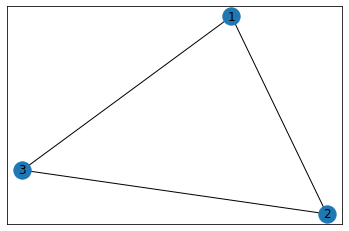

In [4]:
gg = nx.Graph()
gg.add_nodes_from([1,2,3])
gg.add_edge(1, 2)
gg.add_edge(1, 3)
gg.add_edge(2, 3)
nx.draw_networkx(gg)

In [13]:
print(num_paths2(gg, 1,3))

seeds = [1,3]
print(num_2seed_triangles(gg,seeds))

1
1


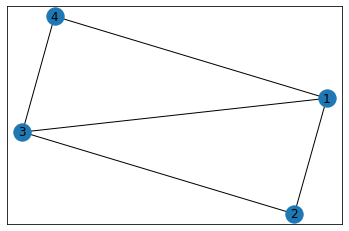

In [14]:
gg = nx.Graph()
gg.add_nodes_from([1,2,3,4])
gg.add_edges_from([(1, 2), (1, 3), (2, 3), (1,4), (3,4)])

nx.draw_networkx(gg)

In [16]:
print(num_paths2(gg, 1,3))

seeds = [1,3]
print(num_2seed_triangles(gg,seeds))

seeds = [1,4]
print(num_2seed_triangles(gg,seeds))

2
2
1


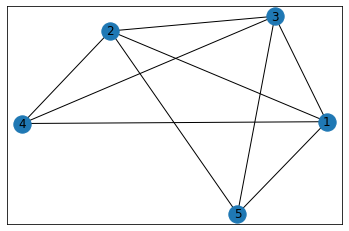

In [19]:
gg = nx.Graph()
gg.add_nodes_from([1,2,3,4,5])
gg.add_edges_from([(1, 2), (1, 3), (2, 3), (1,4), (3,4), (4,2), (5,1), (5,2), (5,3)])

nx.draw_networkx(gg)

In [23]:
print(num_paths2(gg, 1,5))

seeds = [4,5]
print(num_2seed_triangles(gg,seeds))

seeds = [5,1]
print(num_2seed_triangles(gg,seeds))

seeds = [5,1,2]
print(num_2seed_triangles(gg,seeds))

2
0
2
4


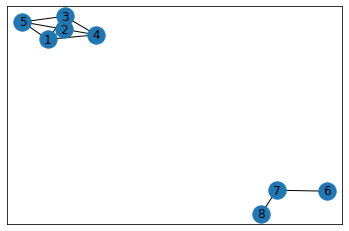

In [24]:
#EDGE CASE: more than one connected component
gg = nx.Graph()
gg.add_nodes_from([1,2,3,4,5, 6,7,8])
gg.add_edges_from([(1, 2), (1, 3), (2, 3), (1,4), (3,4), (4,2), (5,1), (5,2), (5,3),
                  (6,7), (7,8)])

nx.draw_networkx(gg)

In [25]:
#SHOULD BE SAME AS ABOVE
print(num_paths2(gg, 1,5))

seeds = [4,5]
print(num_2seed_triangles(gg,seeds))

seeds = [5,1]
print(num_2seed_triangles(gg,seeds))

seeds = [5,1,2]
print(num_2seed_triangles(gg,seeds))

2
0
2
4


## The idea of a measure

Recall: the transitivity was 
$$3\frac{\#triangles}{\#connected triples}$$

*Note*: (see first week lec)

a connected triple (i)-(j)-(k)
contains two paths length 2: {i,j,k}, {k,j,i}

From our discussions (also see original seeding paper), the probability of a nontargeted node getting the innovation is affected by two things:

- the number of alters that are targeted
- whether two targeted alters are themselves friends

In [ ]:

# (target)  (not target)        (target)  (target)           (target) - (target)
#    \            /        <        \        /        <         \           /
#         (x)                           (x)                           (x)


This triangle property is a possible mechanism to explain the probability of a innovation spreading. the strongest type of influence would come from the third type of connected triple (in code, called `2seed_triangles`)

Some way of measuring the prevlance of such `2seed_triangles`, might be indicative of the success of a seeding method. But how to measure? 

- $$3 \frac{\# 2seed triangles}{\#connected triples}$$

then this is like a 'harsher' version of the transitivity coefficient, where we're only counting **triangles with 2 seeds as vertices.** 

This has a nice relationship wtih the transitivity coefficient in that their ratio

$$3 \frac{\# 2seed triangles}{\#connected triples}/ 3\frac{\#triangles}{\#connected triples} = 
\frac{\# 2seed triangles}{\# triangles}$$

is the proportion of *actual triangles* that are `2seed_triangles`. 

Note this ratio will always $<1$ since `2seed_triangles` are a subset of triangles.  

In [26]:
def num_con_triples(g):
    #solve for #connected triples from the transitivity formula:
    # 3*num_triangles/transitivity = #connected triples
    num_triangles = sum(nx.triangles(g).values()) / 3 #triple-counting each triangle
    trans = nx.transitivity(g)
    
    return (3*num_triangles/trans)

In [27]:
def two_seed_tran(g, seeds):
    return(num_2seed_triangles(g, seeds) / num_con_triples(g))

## testing on karate club

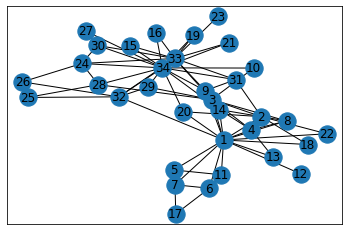

In [28]:
G=nx.read_adjlist("data/karate_edges_77.txt",nodetype=int)
nx.draw_networkx(G,pos=nx.spring_layout(G))

In [46]:
random_tran = []
friend_tran = []
pair_tran = []

nsamp = 1000
p = 0.2

for i in range(0,nsamp):
    random_seeds = get_seeds(G, p, 'random')
    friend_seeds = get_seeds(G, p, 'friend')
    pair_seeds = get_seeds(G, p, 'pair')
    
    random_tran.append(two_seed_tran(G, random_seeds))
    friend_tran.append(two_seed_tran(G, friend_seeds))
    pair_tran.append(two_seed_tran(G, pair_seeds))

In [48]:
df = pd.DataFrame({"2-seed transitivity":random_tran + friend_tran + pair_tran,
                   "seeding method": ['random']*nsamp + ['friend']*nsamp + ['pair']*nsamp})
df

,2-seed transitivity,seeding method
0,0.005871,random
1,0.005871,random
2,0.009785,random
3,0.009785,random
4,0.005871,random
...,...,...
2995,0.021526,pair
2996,0.023483,pair
2997,0.017613,pair
2998,0.023483,pair


In [49]:
import plotly.express as px
fig = px.box(df, x="seeding method", y="2-seed transitivity")
fig.show()

It is expected that the friend method will give higher `2-seed transitivity` than pair method. 
By the frienship paradox, both seeds in the friend method will have higher degree than the original egos.


But in the pair method, the ego in the pair (on average) has lower degree than the alter. And intuitively, we know that nodes with higher degrees are more likely to be involved in triangles (in small world networks for example, triangles mostly form around the hubs). So the friend method would likely have seeds involved in more triangles. 


What's interesting, is that the original seeding paper: no sig difference between effectiveness of friend and pair method. But here, there is difference in their `2-seed transitivity`. 

- It could be that, despite friend having larger `2-seed transitivity`, the scale is still very small. 